In [1]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [2]:
os.makedirs('results', exist_ok=True)

In [3]:
dir_path = '../../../data/pseudobulks/'

In [4]:
os.listdir(dir_path)

['pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

# ANOVA

Load pseudobulk data

In [5]:
file_name = 'pb_mammals.h5ad'
adata_pb = sc.read_h5ad(dir_path + file_name)
adata_pb

AnnData object with n_obs × n_vars = 94 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

Remove technical replicate

In [6]:
adata_pb = adata_pb[adata_pb.obs.sample_id != 'chimp_13302'].copy()
adata_pb

AnnData object with n_obs × n_vars = 89 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

Calculate library size

In [7]:
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

## Gene filltering

Fillter low expressed genes

In [8]:
adata_pb = adata_pb[:, adata_pb.X.mean(axis=0) > 0.05]
adata_pb

View of AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [9]:
adata_pb.write_h5ad('results/pb_mammals_filtered.h5ad')

## Sample normalization

In [10]:
def subtract_mean(adata):
    # calculate mean gene expr for each sample
    gene_mean_list = []
    sample_layer_list = adata.obs.sample_id.unique().tolist()
    for sample in sample_layer_list:
        gene_mean_list.append(adata[adata.obs.sample_id == sample].X.mean(axis=0).reshape(-1, 1))
    # convert to DataFrame
    gene_mean_df = pd.DataFrame(np.concatenate(gene_mean_list, axis=1), columns=sample_layer_list, index=adata.var_names)
    gene_mean_df.head()
    
    # subtract mean and return adata
    for sample in sample_layer_list:
        columns = adata.obs[adata.obs.sample_id == sample].index.to_list()
        for column in columns:
            adata[column].X = adata[column].X - gene_mean_df.loc[:, sample].values
    return adata

Library size normalization

In [11]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)

normalizing counts per cell
    finished (0:00:00)


D:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Sample normalization

In [12]:
adata_norm = subtract_mean(adata_pb)

In [13]:
sc.pp.pca(adata_norm)

computing PCA
    with n_comps=50
    finished (0:00:00)


In [14]:
# save results
adata_norm.write_h5ad('results/pb_mammals_samplenorm_mean.h5ad')

D:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
D:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


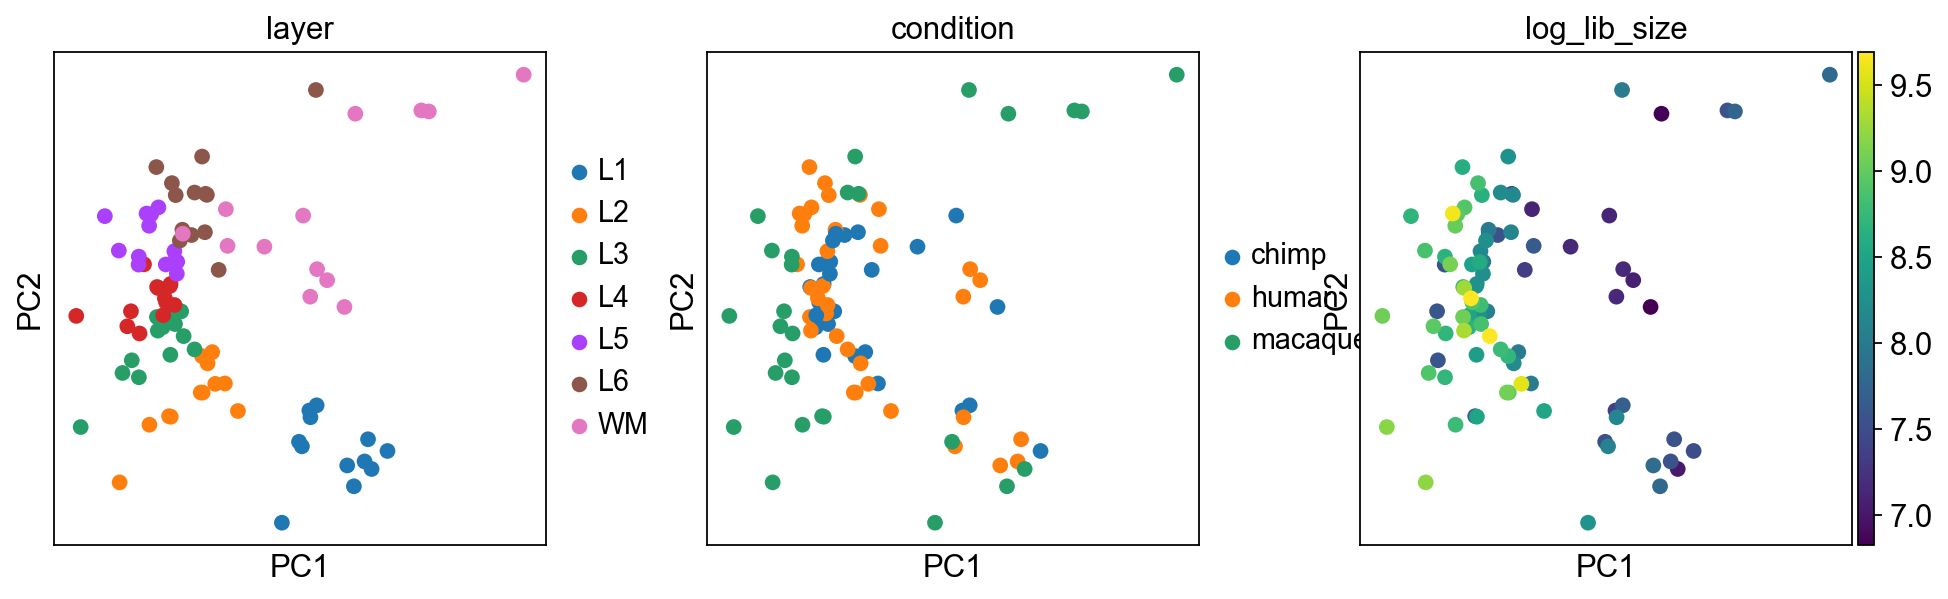

In [15]:
sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

## ANOVA

In [16]:
adata = sc.read_h5ad('results/pb_mammals_samplenorm_mean.h5ad')
adata

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [17]:
# Make df for ANOVA
df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
df['condition'] = adata.obs.condition
df['layer'] = adata.obs.layer
df.head()

,A1BG,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS1,...,ZSWIM7,ZSWIM8,ZUP1,ZWILCH,ZYG11B,ZYX,ZZEF1,ZZZ3,condition,layer
chimp_11454_L1,0.005079,0.073186,-0.108424,0.013291,-0.095572,-0.069955,0.114797,0.029699,-0.004369,0.002562,...,-0.106296,-0.133235,-0.152825,0.028279,-0.013137,0.022066,-0.128826,0.001813,chimp,L1
chimp_13309_L1,-0.014054,-0.035632,-0.004051,-0.002748,0.075461,0.055413,-0.038396,0.008712,0.051290,0.014893,...,-0.049720,0.024958,-0.182668,-0.016176,-0.005356,-0.000944,-0.092394,0.029591,chimp,L1
chimp_j8_L1,0.009907,0.029165,-0.088813,0.001865,0.038888,-0.002917,0.017374,-0.006275,0.011932,0.029188,...,0.021254,0.060017,0.032458,-0.003124,-0.003501,-0.004307,0.111807,0.006668,chimp,L1
human_759_L1,-0.142812,0.114319,-0.068295,0.029625,-0.090127,-0.167612,0.092342,-0.045720,-0.024548,-0.043530,...,-0.010275,-0.013808,-0.004590,-0.084963,-0.053720,0.083597,0.012983,0.007762,human,L1
human_j12_L1,-0.018240,0.003840,-0.116677,-0.055486,-0.000218,-0.126356,0.105158,-0.083792,-0.032703,-0.054107,...,0.074993,0.006322,-0.068134,-0.132802,-0.138752,0.050423,-0.035598,0.056095,human,L1


Replace gene names to `gene{i}` as `statsmodels` may fail

In [18]:
df_var_num = df.copy()
df_var_num.columns = [f'gene{i}' for i in range(1, df_var_num.shape[1] - 1)] + ['condition', 'layer']

In [19]:
# ANOVA for each gene
results = []

for gene in tqdm(df_var_num.columns.tolist()[:-2]):
    formula = f'{gene} ~ condition + layer + condition:layer'
    model = ols(formula, data=df_var_num).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    results.append(aov_table.loc['condition:layer'].tolist())

# save results to df
columns = ['sum_sq', 'df', 'F', 'PR(>F)']
res = pd.DataFrame(results, columns=columns, index=adata.var_names)
res.head()

  0%|          | 0/9208 [00:00<?, ?it/s]

,sum_sq,df,F,PR(>F)
A1BG,0.122578,12.0,2.796490,0.003701
AAAS,0.017527,12.0,0.944161,0.509517
AACS,0.136394,12.0,2.729393,0.004508
AADAT,0.057031,12.0,5.478881,0.000002
AAGAB,0.043359,12.0,2.127609,0.026045


## Multiple comparison correction

In [20]:
# Multiple comparison correction
mult_test = multipletests(res['PR(>F)'], method='fdr_bh')
res['p_val_adj'] = mult_test[1]
res.to_csv(f'results/anova_mamm_mean.csv')

In [21]:
res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


<Axes: >

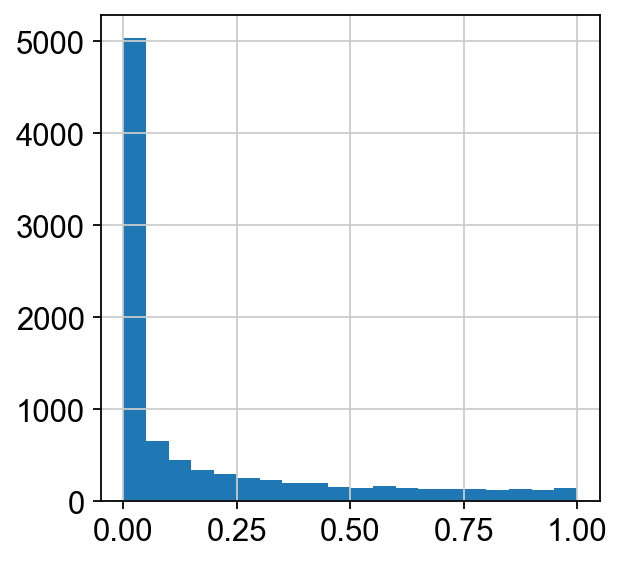

In [22]:
res['PR(>F)'].hist(bins=20)

In [23]:
res[res.p_val_adj < 0.05].shape

(4387, 5)

## t-test

In [24]:
anova_res = pd.read_csv(f'results/anova_mamm_mean.csv', index_col=0)
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


Leave only significant genes

In [25]:
sig_genes = anova_res[res.p_val_adj < 0.05].index
sig_genes

Index(['A1BG', 'AACS', 'AADAT', 'AAK1', 'AARS1', 'AATK', 'ABAT', 'ABCA2',
       'ABCA3', 'ABCA5',
       ...
       'ZNF771', 'ZNF791', 'ZNF92', 'ZNFX1', 'ZNRF3', 'ZSWIM5', 'ZSWIM6',
       'ZWILCH', 'ZYG11B', 'ZYX'],
      dtype='object', length=4387)

In [26]:
from itertools import combinations
layers = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'WM']
conditions = ['human', 'chimp', 'macaque']

In [27]:
from scipy.stats import ttest_ind
from itertools import combinations

columns = ['gene', 'layer', 'group1', 'group2', 'score', 'pvalue']
results = []


for layer in tqdm(layers):
    layer_results = []
    for group1, group2 in combinations(conditions, 2):
        for gene in sig_genes.tolist():
            values1 = df.loc[(df['layer'] == layer) & (df['condition'] == group1), gene].values
            values2 = df.loc[(df['layer'] == layer) & (df['condition'] == group2), gene].values
            ttest_res = ttest_ind(values1, values2)
            layer_results.append([gene, layer, group1, group2, ttest_res.statistic, ttest_res.pvalue])
    # поправка на множественное сравнение
    layer_results = pd.DataFrame(layer_results, columns=columns)
    layer_results.dropna(subset='pvalue', inplace=True)
    mult_test = multipletests(layer_results['pvalue'], method='fdr_bh')
    layer_results['p_val_adj'] = mult_test[1]
    results.append(layer_results)

  0%|          | 0/7 [00:00<?, ?it/s]

In [28]:
ttest_results = pd.concat(results)
ttest_results

,gene,layer,group1,group2,score,pvalue,p_val_adj
0,A1BG,L1,human,chimp,-1.790136,0.123630,0.345077
1,AACS,L1,human,chimp,0.363287,0.728846,0.861269
2,AADAT,L1,human,chimp,0.869717,0.417885,0.645979
3,AAK1,L1,human,chimp,-2.016288,0.090364,0.295232
4,AARS1,L1,human,chimp,-0.056056,0.957117,0.981898
...,...,...,...,...,...,...,...
13156,ZSWIM5,WM,chimp,macaque,2.255914,0.064911,0.208051
13157,ZSWIM6,WM,chimp,macaque,1.573619,0.166640,0.338888
13158,ZWILCH,WM,chimp,macaque,2.727262,0.034310,0.155395
13159,ZYG11B,WM,chimp,macaque,1.650053,0.150025,0.319604


In [29]:
ttest_results.to_csv('results/ttest_mamm_mean.csv')